<a href="https://colab.research.google.com/github/Naoki0424/my_document/blob/main/20211029_orenist_dynamic_filter_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みフィルターの学習をやってみる

## ライブラリのインポート

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import tensorflow as tf
from tensorflow.keras import models, layers, initializers

np.random.seed(20211028)
tf.random.set_seed(20211028)

## 事前準備

In [73]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0   3871      0 --:--:-- --:--:-- --:--:--  3871
100  553k  100  553k    0     0  1809k      0 --:--:-- --:--:-- --:--:-- 8929k


In [74]:
with open('ORENIST.data', 'rb')as file:
  images, labels = pickle.load(file)

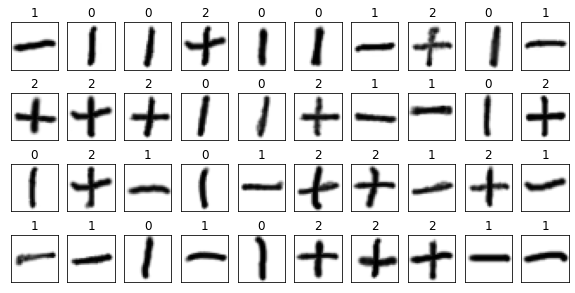

In [75]:
fig = plt.figure(figsize=(10, 5))
for i in range(40):
  subplot = fig.add_subplot(4, 10, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

## ニューラルネットワークの定義

In [76]:
model = models.Sequential()
model.add(layers.Reshape((28, 28, 1), input_shape=(28*28, ), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same', kernel_initializer=initializers.TruncatedNormal(), use_bias=False, name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.MaxPooling2D((28, 28), name='max_pooling'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(3, activation='softmax', name='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter (Conv2D)         (None, 28, 28, 2)         50        
_________________________________________________________________
abs (Lambda)                 (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 1, 1, 2)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
softmax (Dense)              (None, 3)                 9         
Total params: 59
Trainable params: 59
Non-trainable params: 0
__________________________________________________________

`MaxPooling2D()`のサイズを(28, 28)としていて、これは28×28の画像サイズから最大値のピクセルを選び、画像全体を１つのピクセルに置き換えることを意味しています。今回の場合は2種類のフィルターからそれぞれ1ピクセル分の画像が得られることになります

In [77]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

## 学習処理

In [78]:
history = model.fit(images, labels, batch_size=len(images), epochs=2000, verbose=0)

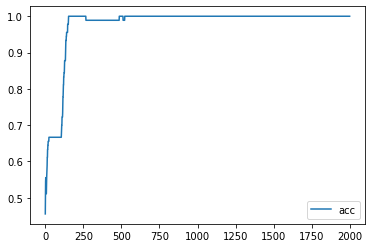

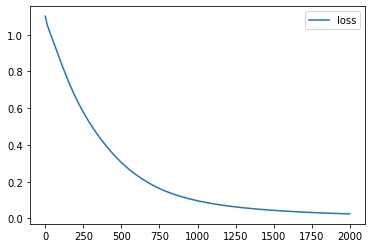

In [79]:
DataFrame({'acc': history.history['acc']}).plot()
DataFrame({'loss': history.history['loss']}).plot()

## 抽出した特徴の可視化

In [80]:
layer_outputs = [model.get_layer('abs').output, model.get_layer('max_pooling').output]
model2 = models.Model(inputs=model.input, outputs=layer_outputs)

In [81]:
conv_output, pool_output = model2.predict(images[:9])
filter_vals = model.get_layer('conv_filter').get_weights()[0]

8.473754


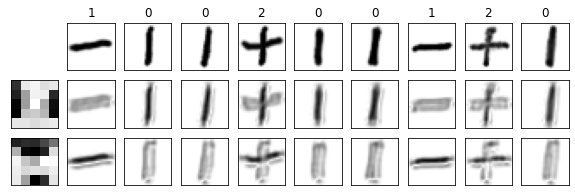

In [86]:
fig = plt.figure(figsize=(10, 3))
v_max = np.max(conv_output)

for i in range(2):
  subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)


for i in range(9):
  subplot = fig.add_subplot(3, 10, i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

  subplot = fig.add_subplot(3, 10, 10+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(conv_output[i, :, :, 0], vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

  subplot = fig.add_subplot(3, 10, 20+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(conv_output[i, :, :, 1], vmin=0, vmax=v_max, cmap=plt.cm.gray_r)
  

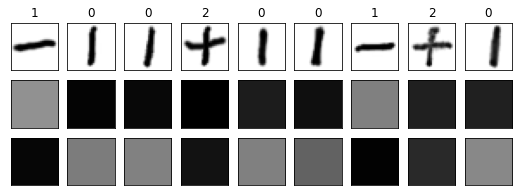

In [88]:
fig = plt.figure(figsize=(10, 3))
v_max = np.max(conv_output)

for i in range(9):
  subplot = fig.add_subplot(3, 10, i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

  subplot = fig.add_subplot(3, 10, 10+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(pool_output[i, :, :, 0], vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

  subplot = fig.add_subplot(3, 10, 20+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(pool_output[i, :, :, 1], vmin=0, vmax=v_max, cmap=plt.cm.gray_r)